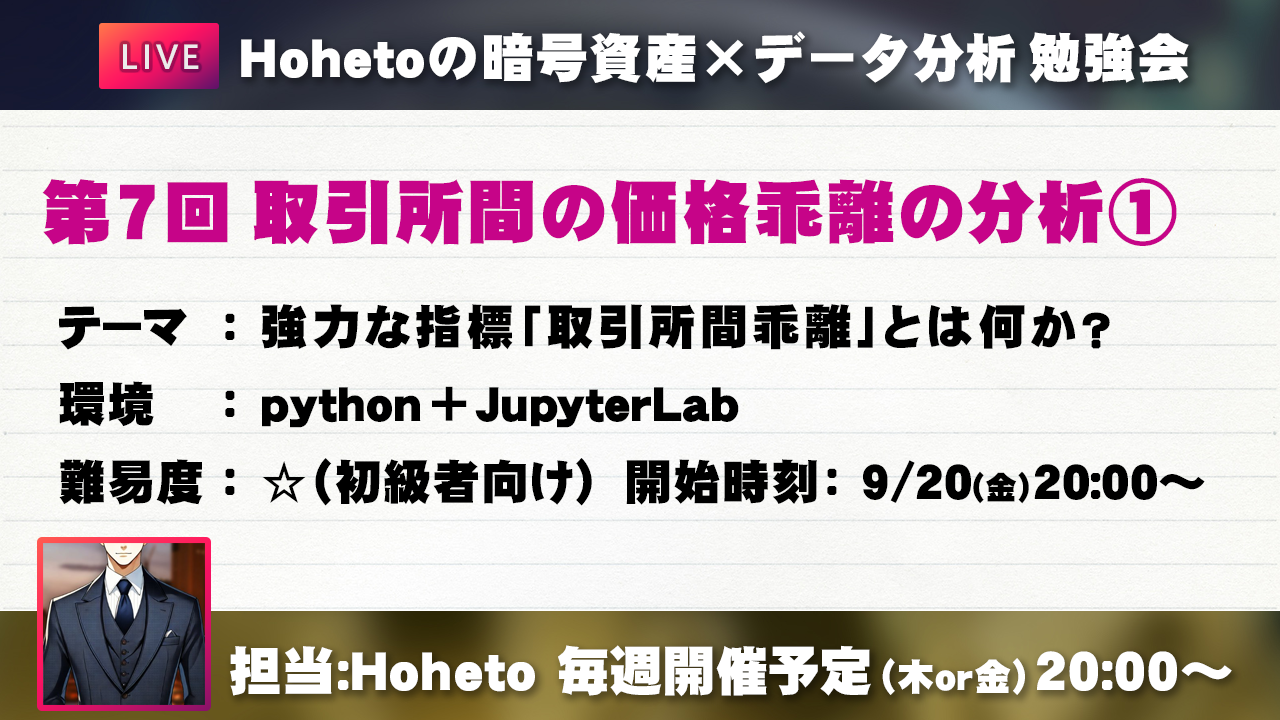

In [1]:
from IPython.display import Image

Image('./images/07_00.png')

# Hoheto勉強会 第7回 取引所間の乖離①

## 免責事項

- この勉強会では、過去のデータ分析を中心に行います。未来の値動きを断定したり投資に関するアドバイスを提供するものではありません。
- 投資は自己責任です。この内容に基づいて視聴者様が行う投資判断やその結果について、配信者は一切の責任を負いません。
- 内容には細心の注意を払っておりますが、正確性を完全に保証するものではありません。

## 概要

- 取引所間で起こる価格差（価格乖離）について解説します。
- この価格乖離が値動きに与える影響を分析します。
- 価格乖離を利用した簡単な戦略を検討します。

## 前提知識

- Python。pandas、numpyなどのライブラリ。
- Jupyter。

## 内容・難易度

- 難易度☆1つ。

# 今回の検証の流れ

- 取引所間の価格乖離とは
- ビットコイン先物の複数の価格データを取得
- 価格乖離の計算、および分析
- 簡単な戦略作成
- まとめ

# 環境設定

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import ccxt
import japanize_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
from datetime import datetime
from tqdm import tqdm
from IPython.display import display, HTML, Image

In [4]:
# warning表示off
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 7

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (4, 4)

# 取引所間の価格乖離とは

- ビットコインは、様々な取引所で売買できる。
  - 国内取引所、海外取引所
  - CEX、DEX
- それぞれの取引所価格は、アービトラージャーやマーケットメイカーなどによってある程度一定の水準に保たれている。

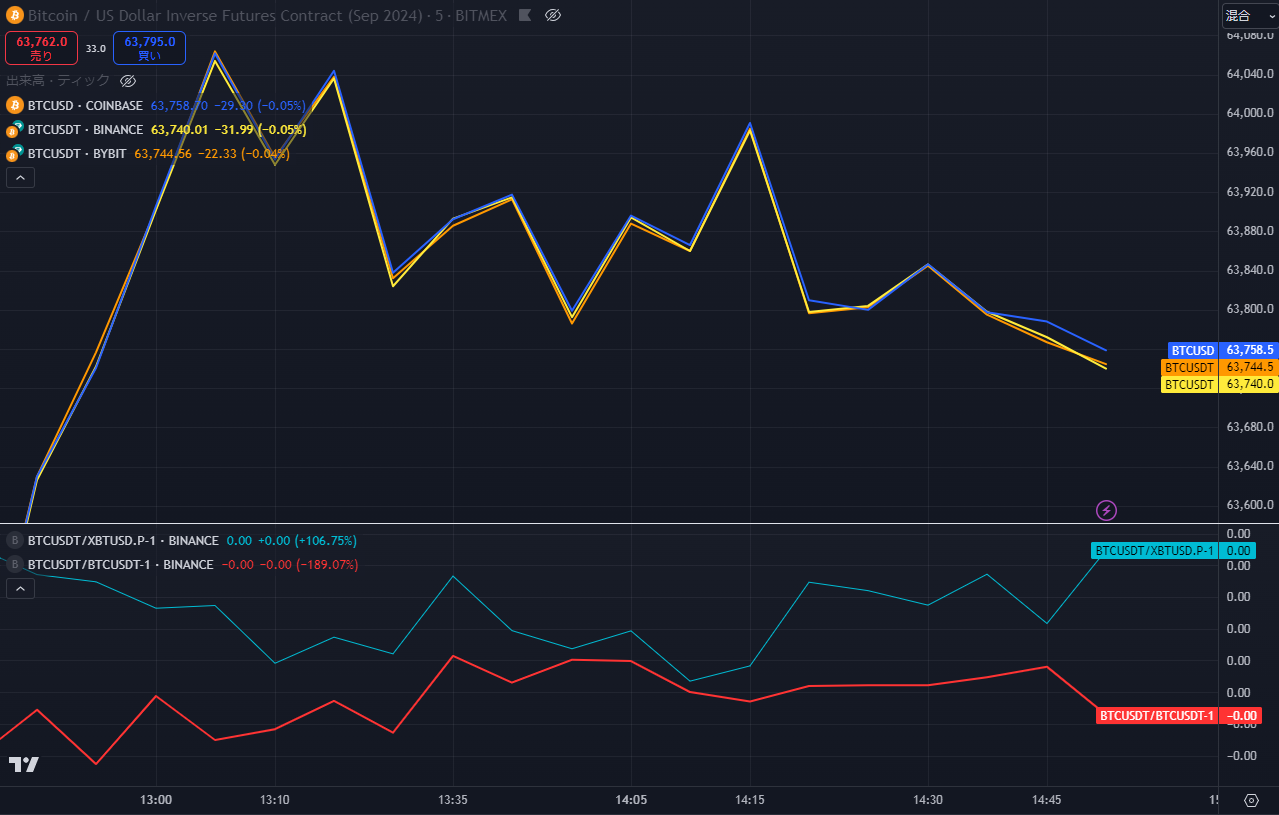

In [5]:
Image('./images/07_01.png', width=800)

- しかし、若干の価格乖離が観測される。
  - よく話題にのぼるのはCoinbase乖離。
  - 一般的には、Coinbaseの上乖離→流入・価格上昇　下乖離→流出・価格下落　のような文脈で使われる。

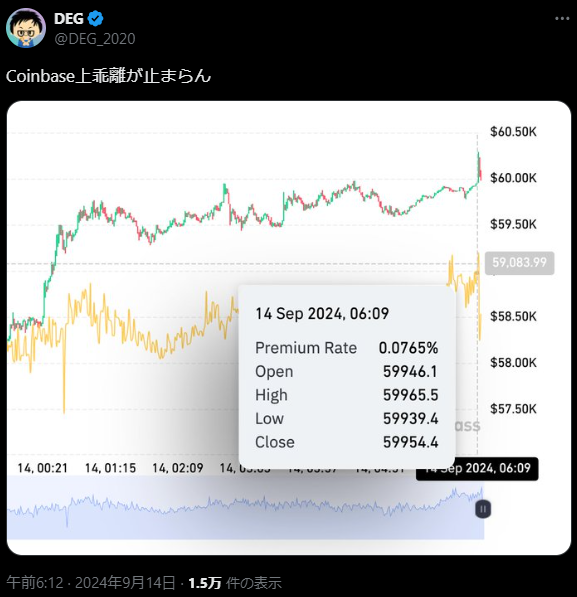

In [6]:
# https://twitter.com/DEG_2020/status/1834701821870563583
Image('./images/07_02.png')

# データ取得

## ビットコイン価格データ取得

- 期間は2023年1月1日～2024年8月31日です。
- 使用データは、
  - BitMEXビットコイン先物 XBTUSD
  - MEXCビットコイン先物 BTCUSDT
  - Binanceビットコイン先物 BTCUSDT
  - bybitビットコイン先物 BTCUSDT
  - Coinbaseビットコイン現物 BTCUSD


In [7]:
apis = {
    'bitmex': ccxt.bitmex(),
    'mexc': ccxt.mexc({'options': {'defaultType': 'swap'}}),
    'binance': ccxt.binanceusdm(),
    'bybit': ccxt.bybit(),
    'coinbase': ccxt.coinbase(),
}

- ccxtを利用してOHLCVを取得する関数

In [8]:
from dateutil import parser

def fetch_ohlcv(exchange, symbol, from_date, to_date, timeframe):
    from_time = int(parser.parse(from_date).timestamp() * 1000)
    to_time = int(parser.parse(to_date).timestamp() * 1000)
    start_time = from_time
    limit = 1000
    ohlcv_list = []
    while True:
        if type(exchange) == str:
            api = apis[exchange]
        else:
            api = exchange
        ohlcv = api.fetch_ohlcv(symbol=symbol, timeframe=timeframe, since=start_time, limit=limit)
        if len(ohlcv) == 0:
            break
        ohlcv_list += ohlcv
        start_time = ohlcv[-1][0] + 1
        # print(f'{datetime.fromtimestamp(ohlcv[-1][0] / 1000)}')
        if start_time > to_time:
            break
        time.sleep(1)
    df = pd.DataFrame(ohlcv_list)
    df.columns = ['timestamp', 'open', 'high', 'log', 'close', 'volume']
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s', utc=True)
    df = df.set_index('timestamp').sort_index()
    df['ror'] = (df['close'] - df['open']) / df['open']
    df.columns = [f'{exchange}_{column}' for column in df.columns]
    return df

- 相関をプロットする関数

In [9]:
def plot_corr(series1, series2, title='', xlabel='', ylabel=''):
    corr = series1.corr(series2)
    plt.title(f'{title} (corr={corr:.3f})')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.scatter(series1, series2, alpha=0.5, s=8, label=f'{corr:.3f}')
    plt.legend()

In [10]:
from_date = '2023-01-01'
to_date = '2024-08-31'

In [11]:
ohlcv_1d = {}

- BitMEX
  - インバース契約（BTCを証拠金にして、ドル単位の契約を売買する）
  - 契約単位がUSDなので、Volumeを簡易的にClose価格で割ります。

In [12]:
ohlcv_1d['bitmex'] = fetch_ohlcv('bitmex', 'XBTUSD', from_date, to_date, '1d')
ohlcv_1d['bitmex']['bitmex_volume'] = ohlcv_1d['bitmex']['bitmex_volume'] / ohlcv_1d['bitmex']['bitmex_close']

In [13]:
ohlcv_1d['bitmex']

,bitmex_open,bitmex_high,bitmex_log,bitmex_close,bitmex_volume,bitmex_ror
timestamp,,,,,,
2023-01-01 00:00:00+00:00,16522.0,16618.0,16482.0,16610.0,4617.375075,0.005326
2023-01-02 00:00:00+00:00,16610.0,16789.5,16544.5,16670.0,10689.976005,0.003612
2023-01-03 00:00:00+00:00,16670.0,16765.0,16596.0,16656.0,10898.787224,-0.000840
2023-01-04 00:00:00+00:00,16656.0,16978.0,16639.5,16842.5,14409.458216,0.011197
2023-01-05 00:00:00+00:00,16842.5,16872.0,16750.5,16818.0,8199.970270,-0.001455
...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,63334.7,63978.3,62314.3,63576.8,4177.961143,0.003823
2024-09-23 00:00:00+00:00,63576.8,64722.5,62478.0,63313.4,4978.819650,-0.004143
2024-09-24 00:00:00+00:00,63313.4,64682.9,62669.6,64245.0,4928.570317,0.014714


- MEXC
  - 契約単位が 1 Contract = 0.0001 BTCなので、Volumeに0.0001を掛けます。

In [14]:
ohlcv_1d['mexc'] = fetch_ohlcv('mexc', 'BTC/USDT:USDT', from_date, to_date, '1d')
ohlcv_1d['mexc']['mexc_volume'] = ohlcv_1d['mexc']['mexc_volume'] * 0.0001  # 1 contract = 0.0001 BTC

- Binance

In [15]:
ohlcv_1d['binance'] = fetch_ohlcv('binance', 'BTC/USDT:USDT', from_date, to_date, '1d')

 - bybit

In [16]:
ohlcv_1d['bybit'] = fetch_ohlcv('bybit', 'BTC/USDT:USDT', from_date, to_date, '1d')

- Coinbase

In [17]:
ohlcv_1d['coinbase'] = fetch_ohlcv('coinbase', 'BTC/USD', from_date, to_date, '1d')

## リターンの比較

In [18]:
df_ror = pd.concat(ohlcv_1d.values(), axis=1).filter(regex='_ror$')

In [19]:
df_ror

,bitmex_ror,mexc_ror,binance_ror,bybit_ror,coinbase_ror
timestamp,,,,,
2023-01-01 00:00:00+00:00,0.005326,0.004414,0.004402,0.004411,0.004824
2023-01-02 00:00:00+00:00,0.003612,0.003389,0.003347,0.002737,0.003314
2023-01-03 00:00:00+00:00,-0.000840,0.000030,0.000078,0.000120,0.000157
2023-01-04 00:00:00+00:00,0.011197,0.010500,0.010488,0.010648,0.010527
2023-01-05 00:00:00+00:00,-0.001455,-0.001098,-0.001092,-0.001276,-0.001111
...,...,...,...,...,...
2024-09-22 00:00:00+00:00,0.003823,0.003757,0.003755,0.003766,0.003392
2024-09-23 00:00:00+00:00,-0.004143,-0.004034,-0.004036,-0.003840,-0.003799
2024-09-24 00:00:00+00:00,0.014714,0.014867,0.014865,0.014891,0.014747


In [20]:
df_ror.isnull().sum()

bitmex_ror      0
mexc_ror        0
binance_ror     0
bybit_ror       0
coinbase_ror    0
dtype: int64

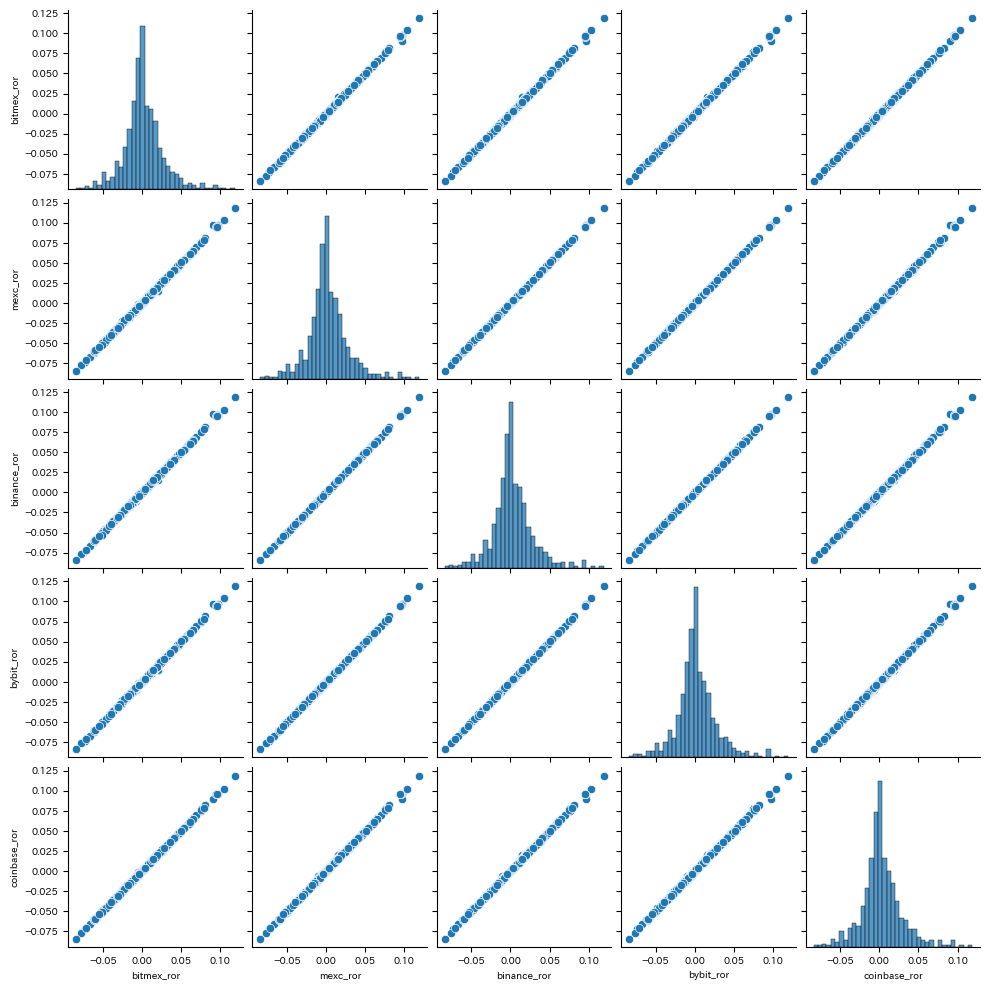

In [21]:
sns.pairplot(df_ror, height=2);

## Volumeの比較

In [22]:
df_volume = pd.concat(ohlcv_1d.values(), axis=1).filter(regex='_volume$')

In [23]:
df_volume

,bitmex_volume,mexc_volume,binance_volume,bybit_volume,coinbase_volume
timestamp,,,,,
2023-01-01 00:00:00+00:00,4617.375075,21402.1394,105502.965,24943.016,10668.736977
2023-01-02 00:00:00+00:00,10689.976005,29200.3370,215161.176,64844.907,13560.460180
2023-01-03 00:00:00+00:00,10898.787224,42312.5371,203070.205,65314.938,17612.355277
2023-01-04 00:00:00+00:00,14409.458216,37980.3599,349747.838,107056.584,25922.706806
2023-01-05 00:00:00+00:00,8199.970270,23089.2836,176369.347,49374.574,14918.229133
...,...,...,...,...,...
2024-09-22 00:00:00+00:00,4177.961143,57279.0521,149129.884,72599.548,2882.234198
2024-09-23 00:00:00+00:00,4978.819650,80663.3403,234343.564,124612.930,7014.382267
2024-09-24 00:00:00+00:00,4928.570317,77395.1340,236987.628,122117.212,8933.464736


- Binance一強からかなり差がつまってきている。

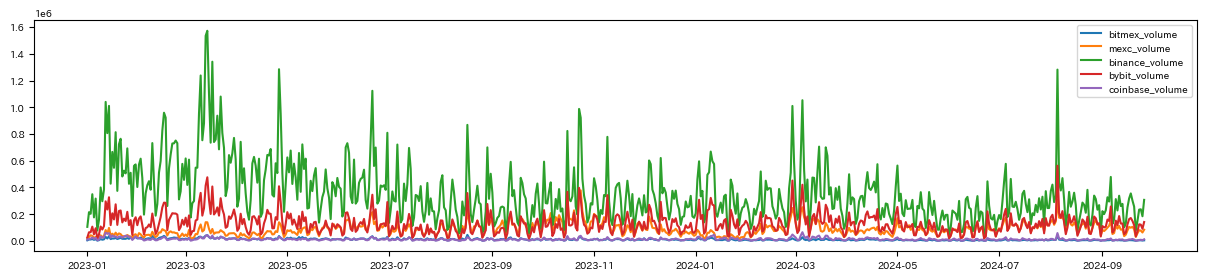

In [24]:
plt.figure(figsize=(15, 3))
plt.plot(df_volume, label=df_volume.columns)
plt.legend();

# 取引所間乖離

## 取引所間乖離の計算

- まずはClose価格のDataFrameを作成します。

In [25]:
df_close = pd.concat(ohlcv_1d.values(), axis=1).filter(regex='_close$')
df_close.columns = [column.replace('_close', '') for column in df_close.columns]

In [26]:
df_close

,bitmex,mexc,binance,bybit,coinbase
timestamp,,,,,
2023-01-01 00:00:00+00:00,16610.0,16610.5,16610.3,16622.5,16611.58
2023-01-02 00:00:00+00:00,16670.0,16666.8,16666.0,16668.0,16666.95
2023-01-03 00:00:00+00:00,16656.0,16667.3,16667.2,16670.0,16669.47
2023-01-04 00:00:00+00:00,16842.5,16842.3,16842.1,16847.5,16844.42
2023-01-05 00:00:00+00:00,16818.0,16823.8,16823.8,16826.0,16825.69
...,...,...,...,...,...
2024-09-22 00:00:00+00:00,63576.8,63558.5,63558.4,63549.9,63577.66
2024-09-23 00:00:00+00:00,63313.4,63302.1,63302.0,63305.9,63338.87
2024-09-24 00:00:00+00:00,64245.0,64243.2,64243.1,64248.6,64272.93


- 乖離の計算をします。

In [27]:
columns = df_close.columns.tolist()
for i in range(len(columns)-1):
    for j in range(i+1, len(columns)):
        df_close[f'{columns[i]}_{columns[j]}_dev'] = df_close[columns[i]] / df_close[columns[j]] - 1

In [28]:
df_dev = df_close.filter(regex='_dev$').copy()

In [29]:
df_dev

,bitmex_mexc_dev,bitmex_binance_dev,bitmex_bybit_dev,bitmex_coinbase_dev,mexc_binance_dev,mexc_bybit_dev,mexc_coinbase_dev,binance_bybit_dev,binance_coinbase_dev,bybit_coinbase_dev
timestamp,,,,,,,,,,
2023-01-01 00:00:00+00:00,-0.000030,-0.000018,-0.000752,-0.000095,0.000012,-0.000722,-0.000065,-0.000734,-0.000077,0.000657
2023-01-02 00:00:00+00:00,0.000192,0.000240,0.000120,0.000183,0.000048,-0.000072,-0.000009,-0.000120,-0.000057,0.000063
2023-01-03 00:00:00+00:00,-0.000678,-0.000672,-0.000840,-0.000808,0.000006,-0.000162,-0.000130,-0.000168,-0.000136,0.000032
2023-01-04 00:00:00+00:00,0.000012,0.000024,-0.000297,-0.000114,0.000012,-0.000309,-0.000126,-0.000321,-0.000138,0.000183
2023-01-05 00:00:00+00:00,-0.000345,-0.000345,-0.000475,-0.000457,0.000000,-0.000131,-0.000112,-0.000131,-0.000112,0.000018
...,...,...,...,...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,0.000288,0.000289,0.000423,-0.000014,0.000002,0.000135,-0.000301,0.000134,-0.000303,-0.000437
2024-09-23 00:00:00+00:00,0.000179,0.000180,0.000118,-0.000402,0.000002,-0.000060,-0.000581,-0.000062,-0.000582,-0.000521
2024-09-24 00:00:00+00:00,0.000028,0.000030,-0.000056,-0.000435,0.000002,-0.000084,-0.000463,-0.000086,-0.000464,-0.000379


In [30]:
df_dev.isnull().sum()

bitmex_mexc_dev         0
bitmex_binance_dev      0
bitmex_bybit_dev        0
bitmex_coinbase_dev     0
mexc_binance_dev        0
mexc_bybit_dev          0
mexc_coinbase_dev       0
binance_bybit_dev       0
binance_coinbase_dev    0
bybit_coinbase_dev      0
dtype: int64

## 乖離の分布

- 分布を取ってみます。
  - 基本的に出来高の多い（＝流動性の高い）取引所同士は乖離が起こりにくいです。
  - MEXCとBinanceの乖離が異常に小さい。これは調査したら何か見つかるかも。
  - Coinbaseはマイナス寄りの不思議な形になっています。

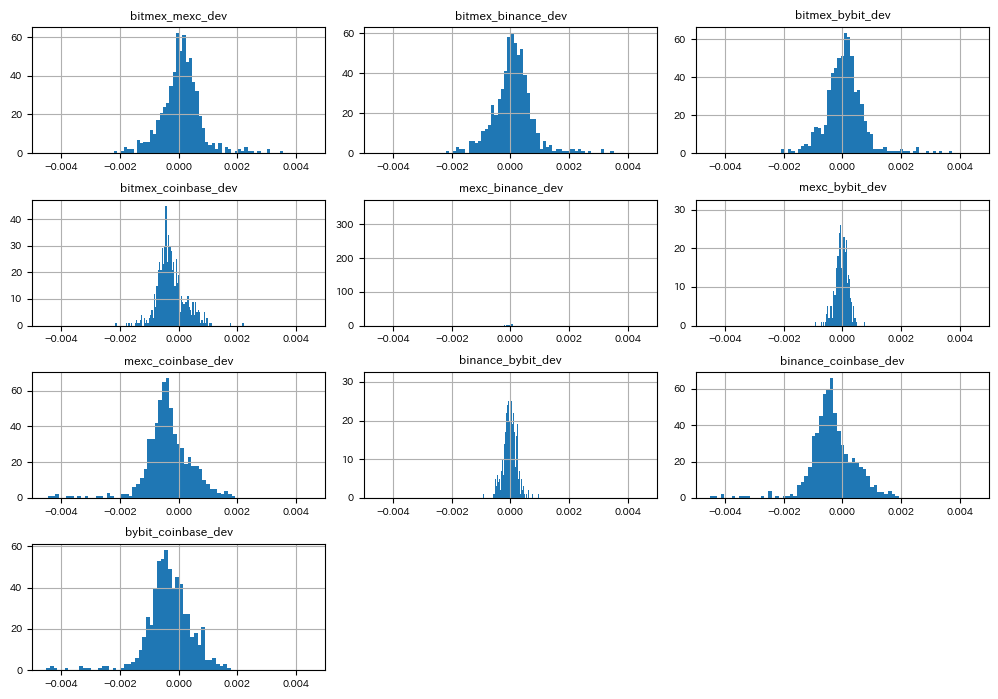

In [31]:
plt.figure(figsize=(10, 7))
for i in range(len(df_dev.columns)):
    plt.subplot(4, 3, i+1)
    column = df_dev.columns.to_list()[i]
    plt.title(column)
    plt.xlim(-0.005, 0.005)
    df_dev[column].hist(bins=100)
plt.tight_layout()
plt.show()

- 縦軸対数バージョンです。

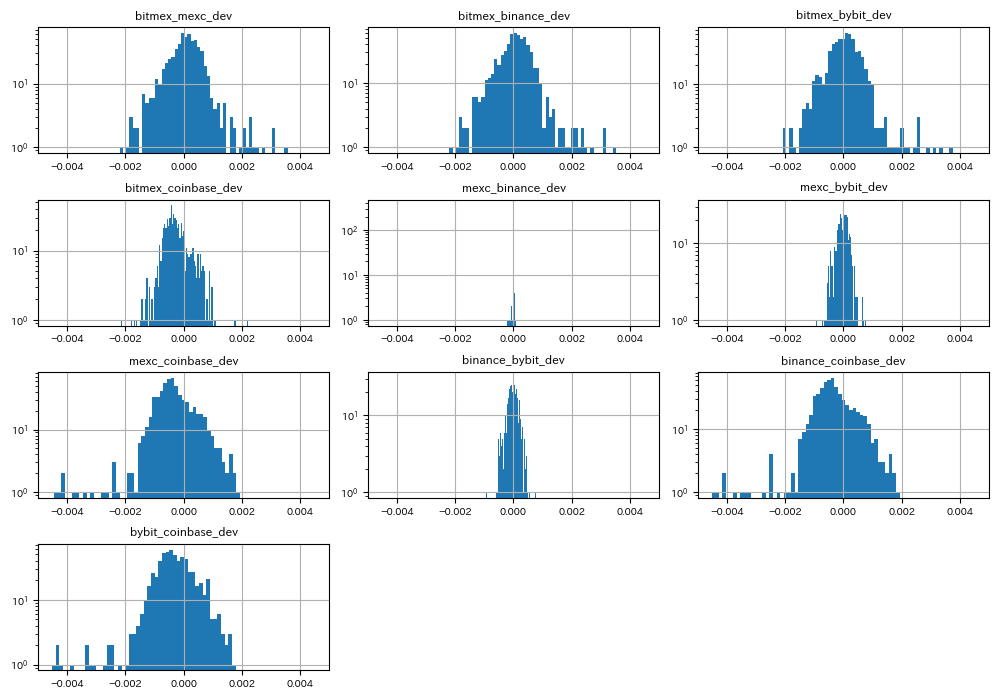

In [32]:
plt.figure(figsize=(10, 7))
for i in range(len(df_dev.columns)):
    plt.subplot(4, 3, i+1)
    column = df_dev.columns.to_list()[i]
    plt.title(column)
    plt.xlim(-0.005, 0.005)
    plt.yscale('log')
    df_dev[column].hist(bins=100)
plt.tight_layout()
plt.show()

- これ以降、MEXC関連の乖離を外します。

In [33]:
df_dev = df_dev.drop(columns=['bitmex_mexc_dev', 'mexc_binance_dev', 'mexc_bybit_dev', 'mexc_coinbase_dev'])

In [34]:
df_dev

,bitmex_binance_dev,bitmex_bybit_dev,bitmex_coinbase_dev,binance_bybit_dev,binance_coinbase_dev,bybit_coinbase_dev
timestamp,,,,,,
2023-01-01 00:00:00+00:00,-0.000018,-0.000752,-0.000095,-0.000734,-0.000077,0.000657
2023-01-02 00:00:00+00:00,0.000240,0.000120,0.000183,-0.000120,-0.000057,0.000063
2023-01-03 00:00:00+00:00,-0.000672,-0.000840,-0.000808,-0.000168,-0.000136,0.000032
2023-01-04 00:00:00+00:00,0.000024,-0.000297,-0.000114,-0.000321,-0.000138,0.000183
2023-01-05 00:00:00+00:00,-0.000345,-0.000475,-0.000457,-0.000131,-0.000112,0.000018
...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,0.000289,0.000423,-0.000014,0.000134,-0.000303,-0.000437
2024-09-23 00:00:00+00:00,0.000180,0.000118,-0.000402,-0.000062,-0.000582,-0.000521
2024-09-24 00:00:00+00:00,0.000030,-0.000056,-0.000435,-0.000086,-0.000464,-0.000379


## 乖離とリターン

### リターンがそれぞれの乖離に与える影響

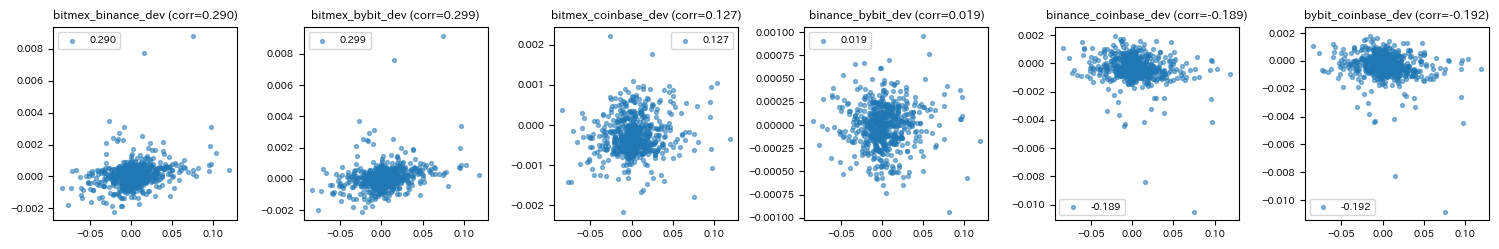

In [35]:
columns = df_dev.columns.to_list()
plt.figure(figsize=(15, 2.5))
for i, column in enumerate(columns):
    plt.subplot(1, 6, i+1)
    plot_corr(df_ror['binance_ror'], df_dev[columns[i]], title=columns[i])
plt.tight_layout()
plt.show()

### 前日の乖離が翌日のリターンに与える影響

- BitMEXとBinance/bybitの前日乖離と翌日のリターンに相関が見られます。
- 同じく、CoinbaseとBinance/bybitの前日乖離と翌日のリターンに相関が見られます。

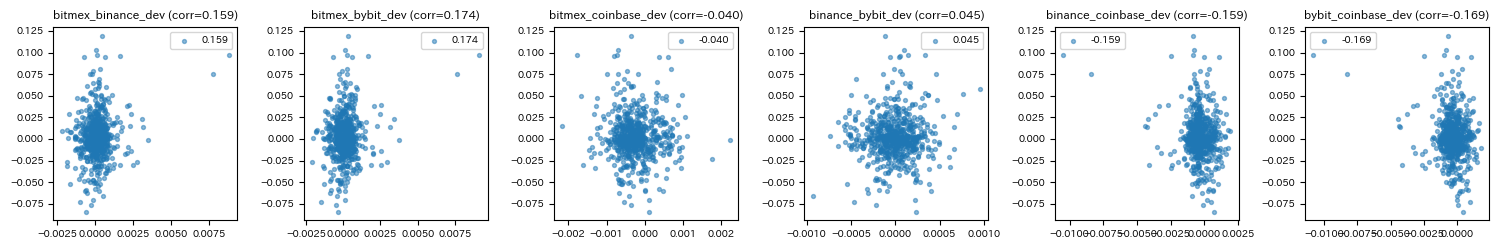

In [36]:
columns = df_dev.columns.to_list()
plt.figure(figsize=(15, 2.5))
for i, column in enumerate(columns):
    plt.subplot(1, 6, i+1)
    plot_corr(df_dev[columns[i]].shift(1), df_ror['binance_ror'], title=columns[i])
plt.tight_layout()
plt.show()

## 乖離変化とリターン

In [37]:
df_dev_diff = df_dev.diff()

In [38]:
df_dev_diff

,bitmex_binance_dev,bitmex_bybit_dev,bitmex_coinbase_dev,binance_bybit_dev,binance_coinbase_dev,bybit_coinbase_dev
timestamp,,,,,,
2023-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02 00:00:00+00:00,0.000258,0.000872,0.000278,0.000614,0.000020,-0.000594
2023-01-03 00:00:00+00:00,-0.000912,-0.000960,-0.000991,-0.000048,-0.000079,-0.000031
2023-01-04 00:00:00+00:00,0.000696,0.000543,0.000694,-0.000153,-0.000002,0.000151
2023-01-05 00:00:00+00:00,-0.000368,-0.000179,-0.000343,0.000190,0.000025,-0.000164
...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,0.000067,0.000057,0.000429,-0.000010,0.000362,0.000372
2024-09-23 00:00:00+00:00,-0.000109,-0.000305,-0.000389,-0.000195,-0.000279,-0.000084
2024-09-24 00:00:00+00:00,-0.000151,-0.000175,-0.000032,-0.000024,0.000118,0.000142


### リターンがそれぞれの乖離変化に与える影響

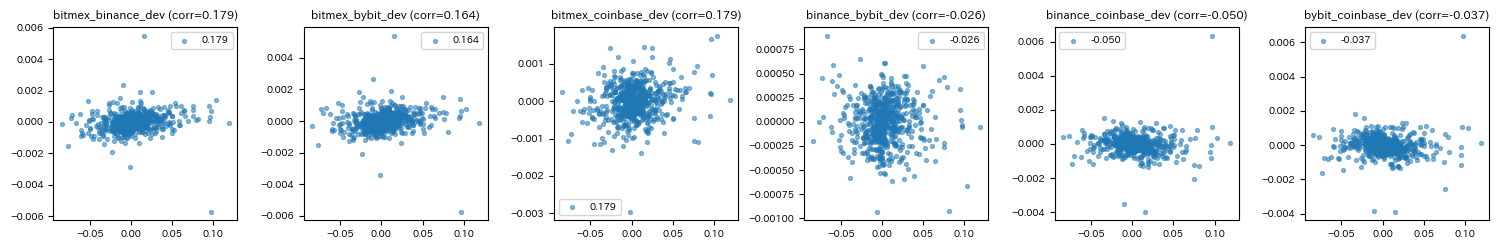

In [39]:
columns = df_dev_diff.columns.to_list()
plt.figure(figsize=(15, 2.5))
for i, column in enumerate(columns):
    plt.subplot(1, 6, i+1)
    plot_corr(df_ror['binance_ror'], df_dev_diff[columns[i]], title=columns[i])
plt.tight_layout()
plt.show()

### 前日の乖離変化が翌日のリターンに与える影響

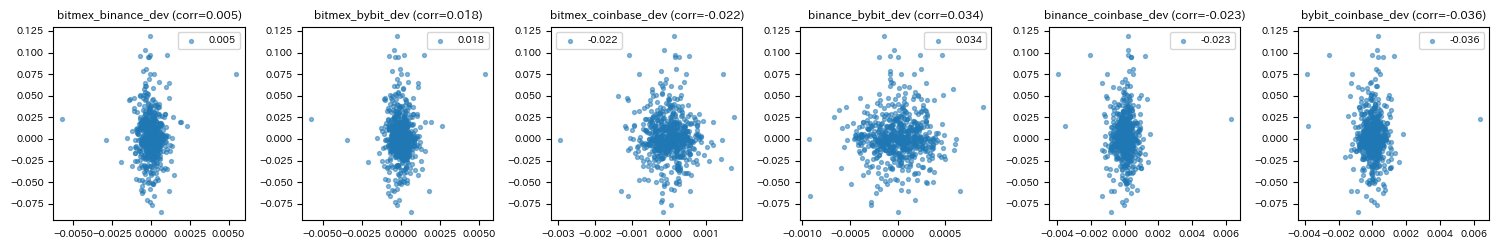

In [40]:
columns = df_dev_diff.columns.to_list()
plt.figure(figsize=(15, 2.5))
for i, column in enumerate(columns):
    plt.subplot(1, 6, i+1)
    plot_corr(df_dev_diff[columns[i]].shift(1), df_ror['binance_ror'], title=columns[i])
plt.tight_layout()
plt.show()

# 戦略作成

## 戦略1 前日のBitMEX-Binance乖離がプラスならロング、マイナスならショート

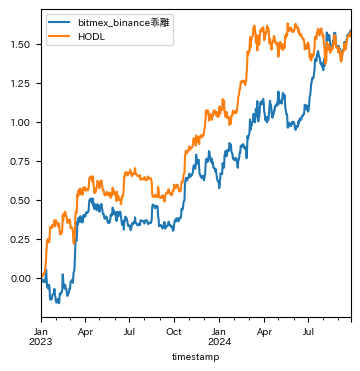

In [41]:
strategy1 = pd.concat([df_ror, df_dev], axis=1)
strategy1['signal'] = np.sign(strategy1['bitmex_binance_dev'].shift(1))
(strategy1['signal'] * strategy1['binance_ror']).cumsum().plot(label='bitmex_binance乖離');
strategy1['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

- HODLに近いパフォーマンスが出ている。
- 思ったよりいける印象。

## 戦略2 前日のBitMEX-Bybit乖離がプラスならロング、マイナスならショート

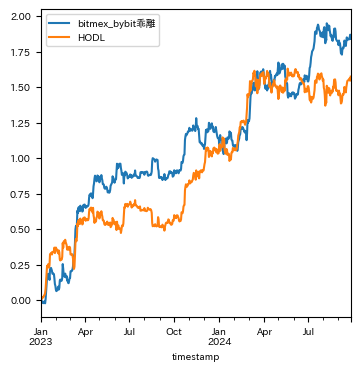

In [42]:
strategy2 = pd.concat([df_ror, df_dev], axis=1)
strategy2['signal'] = np.sign(strategy2['bitmex_bybit_dev'].shift(1))
(strategy2['signal'] * strategy2['binance_ror']).cumsum().plot(label='bitmex_bybit乖離');
strategy2['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

- やはり良好。
- HODLをアウトパフォームしている。

## 戦略3 前日のCoinbase-Binance乖離がプラスならロング、マイナスならショート

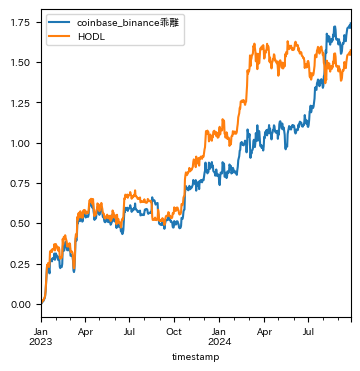

In [43]:
strategy3 = pd.concat([df_ror, df_dev], axis=1)
strategy3['signal'] = -np.sign(strategy3['binance_coinbase_dev'].shift(1))
(strategy3['signal'] * strategy3['binance_ror']).cumsum().plot(label='coinbase_binance乖離');
strategy3['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

## 長期ではどうか？

In [44]:
from_date = '2021-01-01'
to_date = '2024-08-31'
ohlcv_1d = {
    'bitmex': fetch_ohlcv('bitmex', 'XBTUSD', from_date, to_date, '1d'),
    'binance': fetch_ohlcv('binance', 'BTC/USDT:USDT', from_date, to_date, '1d'),
    'bybit': fetch_ohlcv('bybit', 'BTC/USDT:USDT', from_date, to_date, '1d'),
    'coinbase': fetch_ohlcv('coinbase', 'BTC/USD', from_date, to_date, '1d')
}
df_ror = pd.concat(ohlcv_1d.values(), axis=1).filter(regex='_ror$')
df_close = pd.concat(ohlcv_1d.values(), axis=1).filter(regex='_close$')
df_close.columns = [column.replace('_close', '') for column in df_close.columns]
columns = df_close.columns.tolist()
for i in range(len(columns)-1):
    for j in range(i+1, len(columns)):
        df_close[f'{columns[i]}_{columns[j]}_dev'] = df_close[columns[i]] / df_close[columns[j]] - 1
df_dev = df_close.filter(regex='_dev$').copy()

### 戦略1

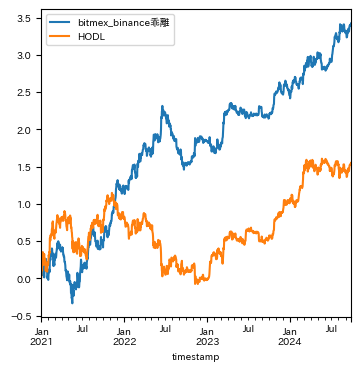

In [45]:
strategy1 = pd.concat([df_ror, df_dev], axis=1)
strategy1['signal'] = np.sign(strategy1['bitmex_binance_dev'].shift(1))
(strategy1['signal'] * strategy1['binance_ror']).cumsum().plot(label='bitmex_binance乖離');
strategy1['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

### 戦略2

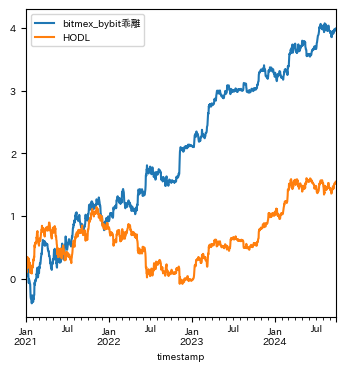

In [46]:
strategy2 = pd.concat([df_ror, df_dev], axis=1)
strategy2['signal'] = np.sign(strategy2['bitmex_bybit_dev'].shift(1))
(strategy2['signal'] * strategy2['binance_ror']).cumsum().plot(label='bitmex_bybit乖離');
strategy2['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

### 戦略3

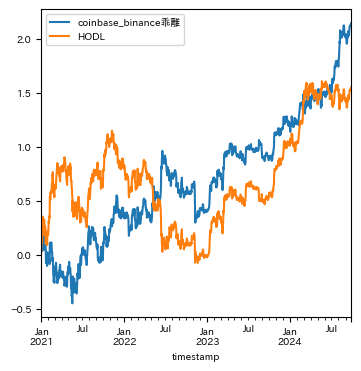

In [47]:
strategy3 = pd.concat([df_ror, df_dev], axis=1)
strategy3['signal'] = -np.sign(strategy3['binance_coinbase_dev'].shift(1))
(strategy3['signal'] * strategy3['binance_ror']).cumsum().plot(label='coinbase_binance乖離');
strategy3['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

- coinbaseがちょっと微妙
- しかし、長期に渡って傾向が持続できている印象を受ける。

# なぜ？

- 乖離同士の相関を取ってみる。
  - Bitmexに対して、Binance乖離とbybit乖離はほぼ同じ。
  - Coinbaseに対して、Binance乖離とbybit乖離はほぼ同じ。
- また、
  - Binanceに対して、Coinbase乖離とBitMEX乖離は相関が強い。
  - bybitに対して、Coinbase乖離とBitMEX乖離は相関が強い。

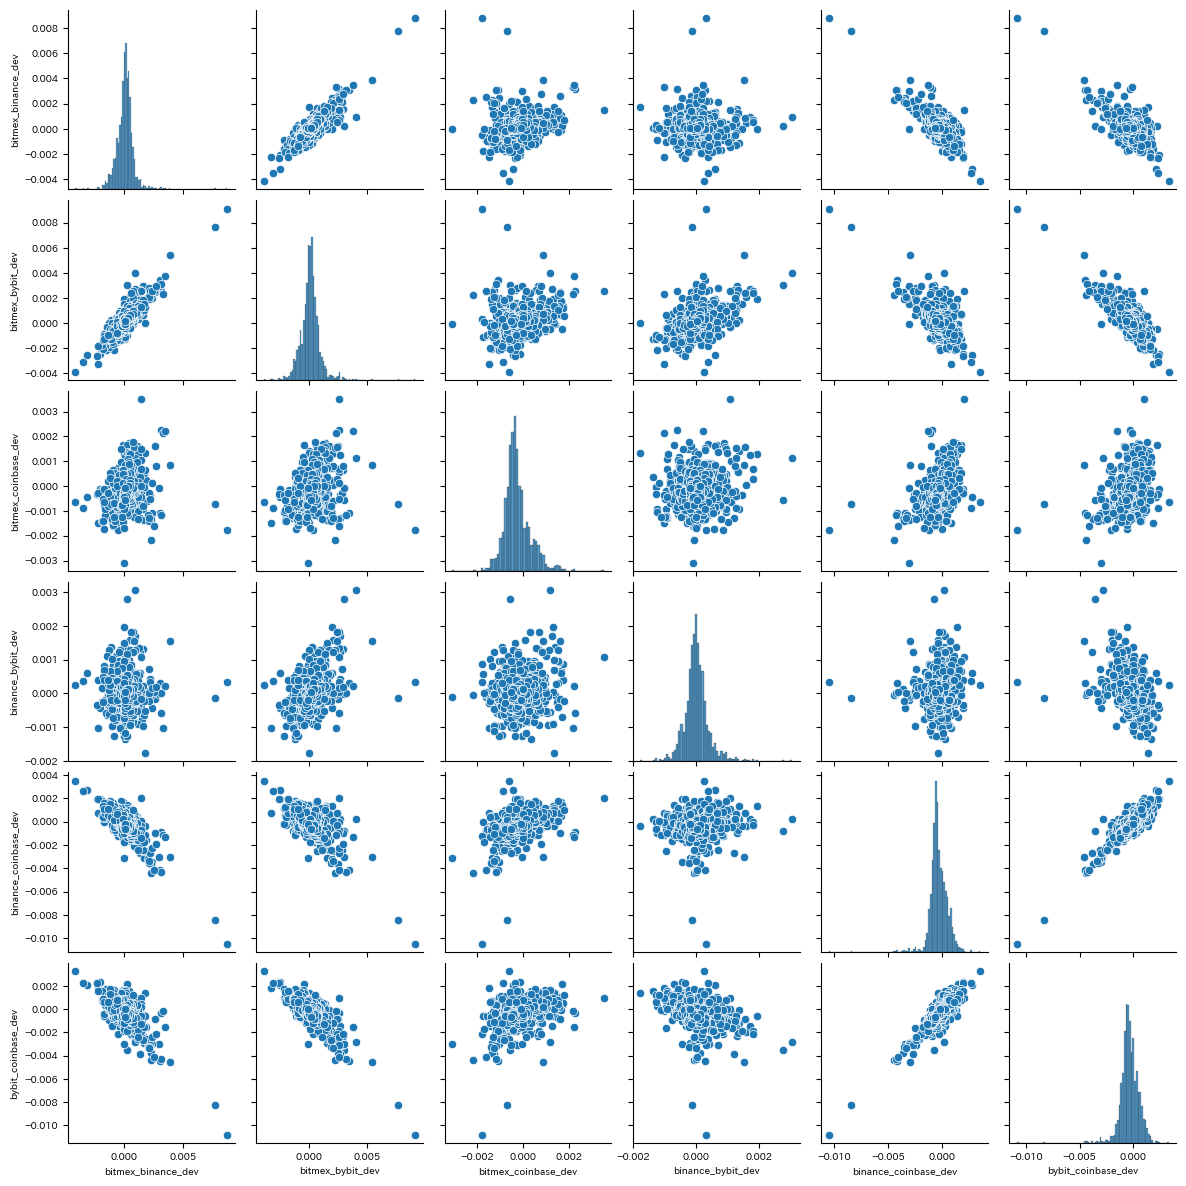

In [48]:
sns.pairplot(df_dev, height=2);

- グループ分けすると、以下が似通っていることになる。
  - グループ1
    - BitMEX（XBTUSD）
    - Coinbase（BTCUSD）
  - グループ2
    - Binance（BTCUSDT）
    - bybit（BTCUSDT）

- これはつまり、USDT/USD
- 効いている指標は、
  - XBT/USD（BitMEX） ÷ BTC/USDT（Binance, bybit） ≒ USDT / USD
  - BTC/USD（Coinbase） ÷ BTC/USDT（Binance, bybit） ≒ USDT / USD

- USDTがUSDに対してプレミアムがついているとき（≒USDTの需要が多いとき）、マーケットが上がりやすい
- USDTがUSDに対してディスカウントされているとき（≒USDTの需要が少ないとき）、マーケットが下がりやすい

## USDT/USDを指標としてトレードしてみる

### CoinbaseのUDST/USD

In [49]:
ohlcv_usdt_1d = fetch_ohlcv('coinbase', 'USDT/USD', '2023-01-01', '2024-08-31', '1d')

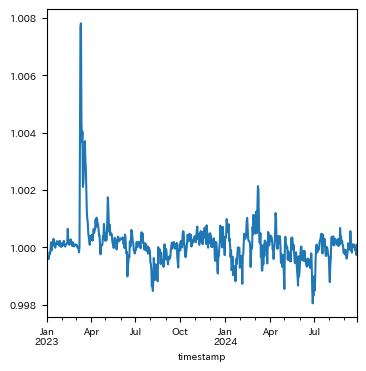

In [50]:
ohlcv_usdt_1d['coinbase_close'].plot();

In [51]:
ohlcv_usdt_1d

,coinbase_open,coinbase_high,coinbase_log,coinbase_close,coinbase_volume,coinbase_ror
timestamp,,,,,,
2023-01-01 00:00:00+00:00,0.99945,0.99960,0.99922,0.99957,2.094424e+07,0.00012
2023-01-02 00:00:00+00:00,0.99957,0.99974,0.99952,0.99969,5.195906e+07,0.00012
2023-01-03 00:00:00+00:00,0.99969,0.99973,0.99953,0.99960,9.405392e+07,-0.00009
2023-01-04 00:00:00+00:00,0.99959,0.99980,0.99954,0.99969,8.295107e+07,0.00010
2023-01-05 00:00:00+00:00,0.99969,0.99978,0.99950,0.99960,5.477187e+07,-0.00009
...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,1.00009,1.00013,0.99972,0.99997,1.182029e+08,-0.00012
2024-09-23 00:00:00+00:00,0.99998,1.00001,0.99972,0.99990,1.775936e+08,-0.00008
2024-09-24 00:00:00+00:00,0.99990,0.99997,0.99974,0.99996,1.565436e+08,0.00006


- 確かに翌日価格と相関がある。

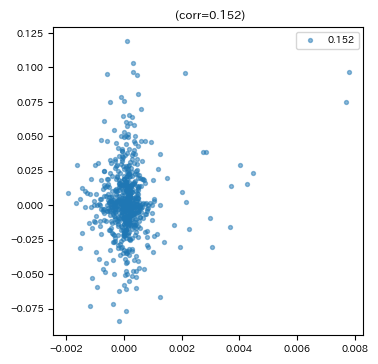

In [52]:
ohlcv_usdt_1d['binance_ror'] = df_ror['binance_ror']
plot_corr((ohlcv_usdt_1d['coinbase_close']-1).shift(1), ohlcv_usdt_1d['binance_ror']);

- 成績はいまいち

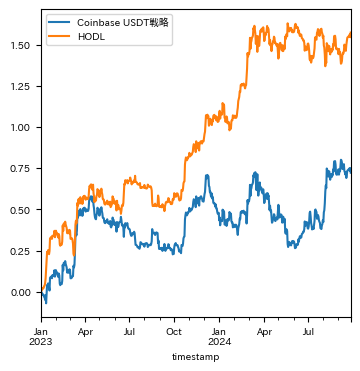

In [53]:
strategy4 = ohlcv_usdt_1d.copy()
strategy4['signal'] = np.sign((strategy4['coinbase_close']-1).shift(1))
(strategy4['signal'] * strategy4['binance_ror']).cumsum().plot(label='Coinbase USDT戦略');
strategy4['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

### KrakenのUDST/USD

- こちらのほうがCoinbaseよりも出来高がある。

In [54]:
ohlcv_usdt_1d = fetch_ohlcv(ccxt.kraken(), 'USDT/USD', '2023-01-01', '2024-08-31', '1d')

In [55]:
ohlcv_usdt_1d

,Kraken_open,Kraken_high,Kraken_log,Kraken_close,Kraken_volume,Kraken_ror
timestamp,,,,,,
2023-01-02 00:00:00+00:00,0.99950,0.99980,0.99940,0.99970,3.958143e+07,0.00020
2023-01-03 00:00:00+00:00,0.99970,0.99970,0.99160,0.99950,1.392672e+08,-0.00020
2023-01-04 00:00:00+00:00,0.99950,1.00000,0.99850,0.99970,1.106925e+08,0.00020
2023-01-05 00:00:00+00:00,0.99960,0.99990,0.99930,0.99960,1.793990e+08,0.00000
2023-01-06 00:00:00+00:00,0.99960,1.00030,0.99920,0.99970,1.599394e+08,0.00010
...,...,...,...,...,...,...
2024-09-22 00:00:00+00:00,1.00032,1.00035,1.00003,1.00016,6.783902e+07,-0.00016
2024-09-23 00:00:00+00:00,1.00016,1.00035,0.99983,1.00000,1.402830e+08,-0.00016
2024-09-24 00:00:00+00:00,1.00000,1.00002,0.99976,1.00000,8.964223e+07,0.00000


- こちらも翌日価格と相関がある。
- CoinbaseのUSDT/USDより相関が強め。

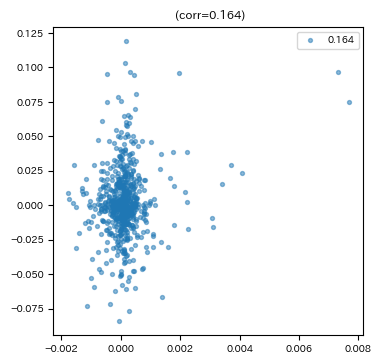

In [56]:
ohlcv_usdt_1d['binance_ror'] = df_ror['binance_ror']
plot_corr((ohlcv_usdt_1d['Kraken_close']-1).shift(1), ohlcv_usdt_1d['binance_ror']);

- HODL程度のパフォーマンスは出る。

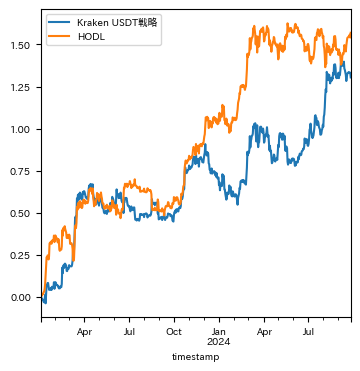

In [57]:
strategy5 = ohlcv_usdt_1d.copy()
strategy5['signal'] = np.sign((strategy5['Kraken_close']-1).shift(1))
(strategy5['signal'] * strategy5['binance_ror']).cumsum().plot(label='Kraken USDT戦略');
strategy5['binance_ror'].cumsum().plot(label='HODL')
plt.legend();

## 考察

- USDTの価格水準が、市況を反映しているものと思われる。
- USDTの需要＝クリプトへの流入の前段階　と考えられ、翌日以降のBTCの価格変化に対して説明力を持っている。
- 取引所乖離の中で説明力があるのは、USDTとUSDの組み合わせ。これが合成USDT/USDペアとなり、翌日・翌々日くらいまで価格への影響を持っている。
- USDT/USD現物ペアよりも、取引所間乖離のほうが若干説明力が高くなっている感じがする（少なくとも損益曲線はきれい）。これは、流動性の高い取引所・ペアを使って合成したほうがより効率的な状態になっている、と考えられる。

- 今回先物で検証したため、取引所間乖離とは別に先物乖離の影響も含まれている可能性がある。
- 先物乖離の分析については別途テーマにする予定

# まとめ

- 前回・今回と役立つ指標が出てきましたがたまたまです。

# 今後

- 実際の運用シミュレーションをする企画を立てたい